In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
cancer = load_breast_cancer()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target)

In [4]:
scaler = MinMaxScaler()

In [5]:
X_train_scaled = scaler.fit_transform(X_train)

In [6]:
clf = LogisticRegression()

In [7]:
clf.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [8]:
X_test_scaled = scaler.fit_transform(X_test)

In [9]:
print("Score: {:.2f}".format(clf.score(X_test_scaled, y_test)))

Score: 0.92


### Parameter Search



In [10]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

In [11]:
from sklearn.model_selection import GridSearchCV

In [12]:
grid = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv = 5)

In [13]:
grid.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [14]:
grid.best_score_

0.9835680751173709

In [15]:
grid.best_params_

{'C': 10}

In [16]:
grid.score(X_test_scaled, y_test)

0.8951048951048951

### Pipeline

In [17]:
from sklearn.pipeline import Pipeline

In [18]:
pipe = Pipeline([("scaler", MinMaxScaler()), ("clf", LogisticRegression())])

In [19]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [20]:
pipe.score(X_test, y_test)

0.965034965034965

In [21]:
#param_grid for pipeline needs step information
param_grid = {'clf__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

In [22]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv = 5)

In [23]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [24]:
grid.best_score_

0.9835680751173709

In [25]:
grid.best_params_

{'clf__C': 10}

### Information Leakage

In [26]:
rnd = np.random.RandomState(seed = 0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size = (100,))

In [27]:
from sklearn.feature_selection import SelectPercentile, f_regression

In [28]:
select = SelectPercentile(score_func = f_regression, percentile = 5)

In [29]:
select.fit(X, y)

SelectPercentile(percentile=5,
         score_func=<function f_regression at 0x10e08f378>)

In [30]:
X_selected = select.transform(X)

In [31]:
X_selected.shape

(100, 500)

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge

In [33]:
#cross validation accuracy
np.mean(cross_val_score(Ridge(), X_selected, y, cv = 5))

0.9057953065239822

In [36]:
#proper approach
pipe = Pipeline([("select", SelectPercentile(score_func=f_regression, percentile = 5)), ("ridge", Ridge())])

In [37]:
np.mean(cross_val_score(pipe, X, y, cv=5))

-0.24655422384952802

### Larger Pipelines

Estimators except the final must have a `transform` method.  Also, we can refer to the steps of a pipeline as

- `pipeline.steps[0][1]` which is the first estimator

- `pipeline.steps[1][1]` is the second estimator

In [38]:
from sklearn.pipeline import make_pipeline

In [39]:
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("clf", LogisticRegression())])

In [40]:
pipe_short = make_pipeline(MinMaxScaler(), LogisticRegression())

In [41]:
pipe_short.steps

[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
 ('logisticregression',
  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False))]

### Adding a GridSearchCV

In [42]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())

In [43]:
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

In [44]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target)

In [45]:
grid = GridSearchCV(pipe, param_grid, cv = 5)

In [46]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [47]:
grid.best_estimator_

Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [48]:
grid.best_estimator_.named_steps

{'logisticregression': LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True)}

In [49]:
grid.best_estimator_.named_steps["logisticregression"]

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [50]:
grid.best_estimator_.named_steps["logisticregression"].coef_

array([[-0.30849113, -0.38248691, -0.30047875, -0.35049068, -0.14343461,
        -0.00060918, -0.32465047, -0.41605999, -0.04153505,  0.12922634,
        -0.49321661,  0.07794796, -0.34220621, -0.45759688,  0.04726974,
         0.26732438,  0.0811106 , -0.05113894,  0.13269765,  0.28420249,
        -0.46589717, -0.52015122, -0.41216953, -0.47440926, -0.4269421 ,
        -0.16014217, -0.37865776, -0.46592366, -0.33436946, -0.16637987]])

### Grid-Search Preprocessing Steps and Model Parameters

In [51]:
from sklearn.datasets import load_boston

In [52]:
boston = load_boston()

In [53]:
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target)

In [54]:
from sklearn.preprocessing import PolynomialFeatures

In [55]:
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

In [56]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
             'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
             'ridge__fit_intercept: [True, False]'}

In [57]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv = 5)

In [58]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'polynomialfeatures__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

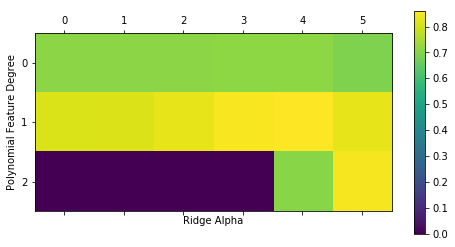

In [59]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1), vmin = 0, cmap = "viridis")
plt.xlabel('Ridge Alpha')
plt.ylabel('Polynomial Feature Degree')
plt.colorbar()

In [60]:
grid.best_params_

{'polynomialfeatures__degree': 2, 'ridge__alpha': 10}

In [61]:
grid.score(X_test, y_test)

0.8302768308786597

In [62]:
#check without polynomial features
param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv = 5)
grid.fit(X_train, y_train)
grid.score(X_test, y_test)

0.6676101255933904

In [63]:
import requests
from bs4 import BeautifulSoup

In [64]:
url = 'https://twitter.com/kanyewest?ref_src=twsrc%5Egoogle%7Ctwcamp%5Eserp%7Ctwgr%5Eauthor'

In [65]:
req = requests.get(url)

In [66]:
soup = BeautifulSoup(req.text, 'html.parser')

In [68]:
soup

<!DOCTYPE html>

<html data-scribe-reduced-action-queue="true" lang="en">
<head>
<meta charset="utf-8"/>
<script nonce="K3+bcszfilpoAXJcphum9w==">
        !function(){window.initErrorstack||(window.initErrorstack=[]),window.onerror=function(r,i,n,o,t){r.indexOf("Script error.")>-1||window.initErrorstack.push({errorMsg:r,url:i,lineNumber:n,column:o,errorObj:t})}}();
      </script>
<script id="bouncer_terminate_iframe" nonce="K3+bcszfilpoAXJcphum9w==">
    if (window.top != window) {
  window.top.postMessage({'bouncer': true, 'event': 'complete'}, '*');
}
  </script>
<script id="swift_action_queue" nonce="K3+bcszfilpoAXJcphum9w==">
    !function(){function e(e){if(e||(e=window.event),!e)return!1;if(e.timestamp=(new Date).getTime(),!e.target&&e.srcElement&&(e.target=e.srcElement),document.documentElement.getAttribute("data-scribe-reduced-action-queue"))for(var t=e.target;t&&t!=document.body;){if("A"==t.tagName)return;t=t.parentNode}return i("all",o(e)),a(e)?(document.addEventListener||(e